### Tutorial Assitance from: 
- https://towardsdatascience.com/unsupervised-sentiment-analysis-a38bf1906483
- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial#Gensim-Word2Vec%C2%A0Tutorial
- https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

###Dataset from: 
- https://www.trackmyhashtag.com/blog/free-twitter-datasets/
- https://drive.google.com/drive/folders/11w4geFB6p17hFlWseBpHJQbhARINvTOc

In [9]:
# handle imports
import pandas as pd
from google.colab import data_table

import re
import regex

!pip install emoji
import emoji

import html

import multiprocessing
from gensim.models import Word2Vec

from sklearn.cluster import KMeans

from joblib import dump, load

In [ ]:
# read in raw tweets from csv
raw_tweets = pd.read_csv("raw_tweets.csv")
data_table.DataTable(raw_tweets.sample(5000), num_rows_per_page=10)

,content
34755,"""2012 is all about trophies. Play as a team. W..."
72266,"""They’re hilarious in our interview, but in @T..."
130711,"""Who else is counting down the days? \nQuién e..."
4025,"""@wedecideit but also .... why do y’all always..."
68784,"""I just cracked my molar in half on a ranch co..."
...,...
48146,"""Hi https://t.co/z9SsctnnLT"""
68506,"""Look out @lukebryanonline, #ColbySwift is com..."
16579,"""Vaccines are a miracle. We have a shared resp..."
53836,""".@instantdotme’s #NewFameList honorees came t..."


In [ ]:
# define tweet cleaning function
def cleanTweet(tweet):

  # sub out urls, regex: r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
  tweet = regex.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", "URL", tweet)

  # remove apostrophes, quotation marks, and similar (´ ` ˝ ̏  ' " ‘ ’ “ ”) regex: r"[\´\`\˝\ ̏\'\"\‘\’\“\”]*"
  tweet = regex.sub(r"""['´`˝"‘’“”]""", '', tweet)

  # sub out decimals (dddd.dddd) -> (dddd_dec_dddd)
  tweet = regex.sub(r"(\d)(\.)(\d)", r"\1_frac_\3", tweet)

  # sub out fractions (dddd.dddd) -> (dddd_frac_dddd)
  tweet = regex.sub(r"(\d)(\/)(\d)", r"\1_frac_\3", tweet)

  # sub html enitity references for unicode equivalents
  tweet = html.unescape(tweet)

  # pad punctuation with spaces (except @ # _)
  tweet = regex.sub(r"(\p{P}(?<![#@_]))", r" \1 ", tweet)

  # pad /'s with spaces except for in fractions (digit/digit)
  tweet = regex.sub(r"(\D)(\/)(\D)", r"\1 \2 \3", tweet)

  # find emojis
  emojis = re.findall(emoji.get_emoji_regexp(), tweet)

  # pad emojis
  for match in emojis:
    tweet = tweet.replace(match, " "+match+" ")

  # remove extra emoji variant codes
  tweet = regex.sub(r"\s\ufe0f\s", ' ', tweet)

  # find user mentions
  users = regex.findall(r"@\S*", tweet)

  # sub out user mentions
  for count, match in enumerate(users):
    tweet = tweet.replace(match, " user"+str(count+1)+" ")

  # find hashtags
  hashtags = regex.findall(r"(#\S*)", tweet)

  # transform to lowercase
  tweet = tweet.lower()

  # re-sub in the hashtags (#original: as lower) -> (#OrigiNal: as captured)
  for match in hashtags:
    tweet = tweet.replace(match.lower(), match)

  # replace all whitespace with single spaces
  tweet = regex.sub(r"(?<!^)[\s]+(?!$)", ' ', tweet)

  # return the clean tweet
  return tweet


In [ ]:
# demo what a clean tweet looks like
raw_tweet = raw_tweets.sample().iloc[0]['content']
clean_tweet = cleanTweet(raw_tweet)

print(raw_tweet, '\n')
print(clean_tweet)

"@stans567 Thank you so much!! So glad you could make it to the Birmingham show 💕" 

 user1 thank you so much ! ! so glad you could make it to the birmingham show 💕 


In [ ]:
# clean all the tweets (computationally expensive)
clean_tweets = raw_tweets.apply(lambda row: cleanTweet(row['content']), axis=1, result_type='broadcast')

In [ ]:
# save clean_tweets to csv
clean_tweets.to_csv('clean_tweets.csv', index=False)

In [ ]:
# read clean tweets in from csv
clean_tweets = pd.read_csv('clean_tweets.csv')

In [ ]:
# split all the tweets
split_clean_tweets = clean_tweets.applymap(lambda content: content.split())

In [ ]:
# show the clean tweets
data_table.DataTable(clean_tweets.sample(5000), num_rows_per_page=10)

,content
146041,user1 a bag full of bookmarks
60856,it takes a village ! ! ! url
38987,of course lebron james and anthony davis had h...
120811,i never saw so many subpoenas ! user1 user2 th...
90375,cant sleeeeeeep
...,...
46530,corned beef is so versatile . .
90688,user1 user2 still debatable hahaha !
53093,throw your wings up for #WHPblackandwhite url url
18724,visit to lucknow slum reminded me - - despite ...


In [ ]:
# show the split clean tweets
data_table.DataTable(split_clean_tweets.sample(5000), num_rows_per_page=10)

,content
87046,"[let, me, teach, you, a, thing, or, two, if, y..."
134433,"[., user1, was, shocked, to, hear, user2, spea..."
113167,"[we, dont, talk, like, this, in, my, house, .,..."
117393,"[instructions, for, living, a, life, :, pay, a..."
140255,"[just, sitting, here, pondering, how, happy, i..."
...,...
132998,"[sometimes, i, like, to, play, at, being, behi..."
138621,"[t, 3145, -, knowledge, decides, what, to, say..."
129659,"[whos, ready, for, spring, break, …, ., ers, ...."
8951,"[your, most, valuable, asset, is, your, imagin..."


In [ ]:
# build word2vec model
cpu_count = multiprocessing.cpu_count()

w2v_model = Word2Vec(min_count=10,
                     window=3,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cpu_count-1)

w2v_model.build_vocab(split_clean_tweets['content'])

print(w2v_model)

Word2Vec(vocab=14139, size=300, alpha=0.03)


In [ ]:
# train the word2vec model
w2v_model.train(split_clean_tweets['content'], total_examples=w2v_model.corpus_count, epochs=30)

(35172069, 87553440)

In [ ]:
# explore some stuff in the word2vec model!
w2v_model.wv.most_similar(positive=["#ElectionDay"])

[('#GoVote', 0.7036756277084351),
 ('#Vote', 0.6751901507377625),
 ('registration', 0.5569189786911011),
 ('ballot', 0.5126895308494568),
 ('#ImWithHer', 0.5100592374801636),
 ('#vote', 0.4813934564590454),
 ('#KAG', 0.4758704602718353),
 ('#BRITVIDLIAMRITA', 0.47472885251045227),
 ('#VoiceSaveAshland', 0.473604679107666),
 ('#LoveIsLove', 0.46809470653533936)]

In [ ]:
# view 10 random vocab words
import random
for word in random.sample(w2v_model.wv.vocab.keys(), 10):
  print(word)

mexicos
#NoLimesNeeded
cakes
card
civilian
masterpiece
hearings
😔
scott
mat


In [ ]:
# save the word2vec model
w2v_model.save("tweets_w2v.model")

In [ ]:
# read the word2vec model from file
w2v_model = Word2Vec.load("tweets_w2v.model")

In [ ]:
# train kmeans model
tweet_word_vectors = Word2Vec.load("tweets_w2v.model").wv
km_model = KMeans(n_clusters=3, max_iter=2000, random_state=True, n_init=50, precompute_distances=True).fit(X=tweet_word_vectors.vectors)

In [ ]:
# pretty variables for the clusters
cluster_labels = ['negative_cluster_center', 'positive_cluster_center', 'neutral_cluster_center']
negative_cluster_center = km_model.cluster_centers_[0]
positive_cluster_center = km_model.cluster_centers_[1]
neutral_cluster_center = km_model.cluster_centers_[2]

# explore some clusters!
tweet_word_vectors.similar_by_vector(positive_cluster_center, topn=10, restrict_vocab=None)

[('#throwbackriri', 0.5563855171203613),
 ('༌', 0.554563045501709),
 ('keepin', 0.5539780855178833),
 ('🐸', 0.542800784111023),
 ('#WHATNOW', 0.5421327352523804),
 ('#PourItUpVideo', 0.5374959111213684),
 ('🙋🏻\u200d♀️', 0.524112343788147),
 ('4_frac_26', 0.522578239440918),
 ('#NAVY', 0.518751859664917),
 ('🍓', 0.5186895728111267)]

In [ ]:
# save kmeans model
dump(km_model, "tweets_km.model")

['tweets_km.model']

In [ ]:
# read kmeans model from file
kmModel = load("tweets_km.model")

In [ ]:
# load models and do small test
w2vModel = Word2Vec.load("tweets_w2v.model")
kmModel = load("tweets_km.model")

# switch between 'negative_cluster_center', 'positive_cluster_center', and 'neutral_cluster_center' to see different clusters
w2vModel.wv.similar_by_vector(neutral_cluster_center, topn=10, restrict_vocab=None)

[('estambul', 0.8917979001998901),
 ('ipurúa', 0.8878130912780762),
 ('yeda', 0.8792761564254761),
 ('hacia', 0.8758056163787842),
 ('fundación', 0.8675786256790161),
 ('mestalla', 0.8655171394348145),
 ('podrás', 0.8643369674682617),
 ('visita', 0.8598731756210327),
 ('mostrar', 0.8555887341499329),
 ('mano', 0.8555189967155457)]

###Cluster Visualization

In [ ]:
# USE THIS BLOCK WHEN YOU ARE ONLY VISUALIZING
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from joblib import load
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time
import matplotlib.pyplot as plt
import seaborn as sns

# read in raw tweets from csv
raw_tweets = pd.read_csv("raw_tweets.csv")

# read clean tweets in from csv
clean_tweets = pd.read_csv('clean_tweets.csv')

# read the word2vec model from file
w2v_model = Word2Vec.load("tweets_w2v.model")

# read kmeans model from file
km_model = load("tweets_km.model")

# pretty variables for the clusters
cluster_labels = ['negative_cluster_center', 'positive_cluster_center', 'neutral_cluster_center']
negative_cluster_center = km_model.cluster_centers_[0]
positive_cluster_center = km_model.cluster_centers_[1]
neutral_cluster_center = km_model.cluster_centers_[2]

In [21]:
# set up data for plotting

# get the cluster values for each vector
get_cluster_label = np.vectorize(lambda cluster: cluster_labels[cluster])
clusters = get_cluster_label(km_model.predict(w2v_model.wv.vectors))
vectors = w2v_model.wv.vectors

# prepare dataframe
df = pd.DataFrame(vectors)
df['cluster'] = clusters

In [22]:
# perform PCA dimensionality reduction
pca = PCA(n_components=100)
pca_result = pca.fit_transform(vectors)

# store PCS results in the dataframe
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.0584753  0.04280931 0.02994506 0.02554999 0.0229194  0.02107739
 0.01841247 0.01711324 0.01516165 0.01317402 0.01232716 0.01165241
 0.01043665 0.01024055 0.00989526 0.0094018  0.00897065 0.00879832
 0.00847268 0.00806767 0.00789641 0.00776795 0.00763065 0.00746139
 0.00711197 0.00686079 0.00676907 0.00659959 0.00646315 0.00644321
 0.00627498 0.00612341 0.00596384 0.00589052 0.00568864 0.00566132
 0.00554073 0.00548284 0.0053202  0.0052705  0.00524468 0.00508106
 0.00500114 0.00490694 0.00490244 0.00482134 0.00478165 0.0047407
 0.00468949 0.00466371 0.00458124 0.00448089 0.00443106 0.00441171
 0.00437235 0.00429363 0.00419131 0.00415992 0.00412196 0.00409618
 0.00397031 0.00393572 0.00386272 0.00385627 0.00381165 0.00378135
 0.00375798 0.00368642 0.00364104 0.00358684 0.00357312 0.00354243
 0.00350112 0.00344296 0.00340829 0.00337592 0.00336324 0.00332877
 0.00331202 0.00328112 0.00324476 0.00321796 0.0032069  0.00314032
 0.00310771 0.0030

In [24]:
#vperform tsne dimensionality reduction
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=70, n_iter=300)
tsne_results = tsne.fit_transform(vectors)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 14139 samples in 0.603s...
[t-SNE] Computed neighbors for 14139 samples in 150.129s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14139
[t-SNE] Computed conditional probabilities for sample 2000 / 14139
[t-SNE] Computed conditional probabilities for sample 3000 / 14139
[t-SNE] Computed conditional probabilities for sample 4000 / 14139
[t-SNE] Computed conditional probabilities for sample 5000 / 14139
[t-SNE] Computed conditional probabilities for sample 6000 / 14139
[t-SNE] Computed conditional probabilities for sample 7000 / 14139
[t-SNE] Computed conditional probabilities for sample 8000 / 14139
[t-SNE] Computed conditional probabilities for sample 9000 / 14139
[t-SNE] Computed conditional probabilities for sample 10000 / 14139
[t-SNE] Computed conditional probabilities for sample 11000 / 14139
[t-SNE] Computed conditional probabilities for sample 12000 / 14139
[t-SNE] Computed conditional probabilities for 

(-10.0, 10.0)

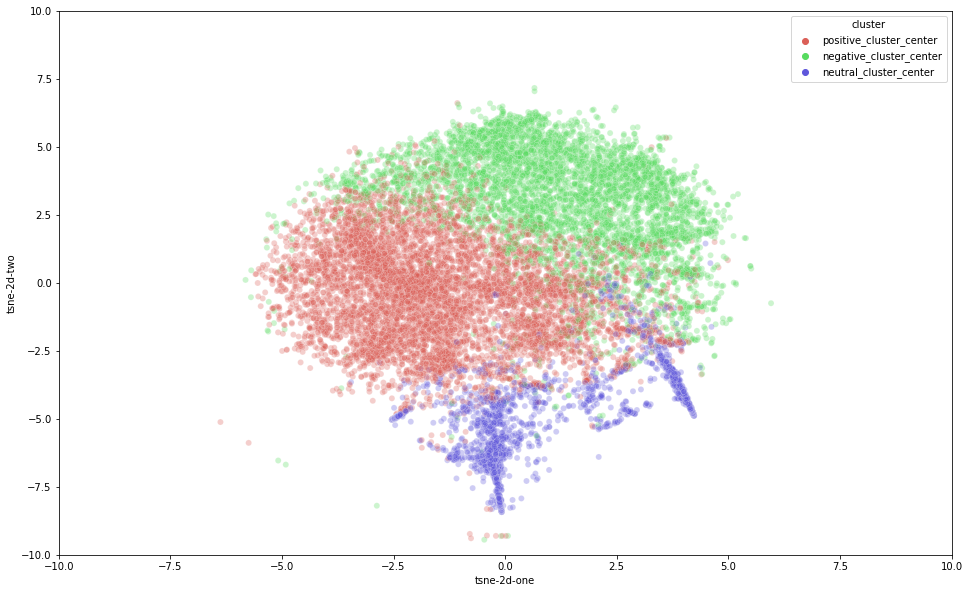

In [27]:
# plot the clusters
plt.figure(figsize=(16,10))
splot = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="cluster",
    palette=sns.color_palette("hls", 3),
    data=df,
    legend="full",
    alpha=0.3
)

# adjust view
plt.xlim([-10, 10])
plt.ylim([-10, 10])